In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import gc
from multiprocessing import Process, Queue

import os
import numpy as np
import pandas as pd
from datetime import date
from tqdm import tqdm

from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from sklearn.metrics import confusion_matrix
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt
import multiprocessing as mp

pd.set_option('display.max_rows', 100)

store_stocks_dict = dict()
store_indexes_dict = dict()

## Loading and utils

### Basics

In [2]:
def update_stocks():
    os.system("rm mstcgl*.zip")
    #os.system("rm mstcgl.zip -d data/")
    os.system("wget https://info.bossa.pl/pub/ciagle/mstock/mstcgl.zip")
    os.system("rm -rf data/*")
    os.system("unzip mstcgl.zip -d data/")

    print(f'Updated {date.today()}, max actual date: \
    {prepare_data("WIG20", reset=True).index.max().strftime(format = "%Y-%m-%d")}')
    
    
def update_stocks_nc():
    os.system("rm mstncn.zip")
    #os.system("rm mstcgl.zip -d data/")
    os.system("wget https://info.bossa.pl/pub/newconnect/mstock/mstncn.zip")
    #os.system("rm -rf data/*")
    os.system("unzip mstncn.zip -d data/")

    print(f'Updated {date.today()}, max actual date: \
    {prepare_data("CLOUD", reset=True).index.max().strftime(format = "%Y-%m-%d")}')


def update_indexes():
    os.system("rm mstzgr*.zip")
    #os.system("rm mstzgr.zip -d data_for/")
    os.system("wget https://moja.info.bossa.pl/pub/indzagr/mstock/mstzgr.zip")
    os.system("rm -rf data_for/*")
    os.system("unzip mstzgr.zip -d data_for/")

    print(f'Updated {date.today()}, max actual date: \
    {prepare_index("NIKKEI").index.max().strftime(format = "%Y-%m-%d")}')


def prepare_data(paper, reset=False):

    if 'mst' in paper:
        paper = str(paper).rstrip('.mst')

    if (paper in store_stocks_dict.keys()) & (reset==False):
        df = store_stocks_dict[paper].copy()
    else:
        df = pd.read_csv(f'data/{paper}.mst')

        df.columns = [str(c).replace('<', '') for c in df.columns]
        df.columns = [str(c).replace('>', '') for c in df.columns]

        df.loc[:, 'DTYYYYMMDD'] = pd.to_datetime(df.loc[:, 'DTYYYYMMDD'],
                                                 format='%Y%m%d')

        df = df.set_index('DTYYYYMMDD')

        store_stocks_dict[paper] = df.copy()

    return df


def prepare_index(indeks, reset=False):

    if 'mst' in indeks:
        indeks = str(indeks).rstrip('.mst')

    if (indeks in store_indexes_dict.keys()) & (reset==False):
        df = store_indexes_dict[indeks].copy()
    else:
        df = pd.read_csv(f'data_for/{indeks}.mst')

        df.columns = [str(c).replace('<', '') for c in df.columns]
        df.columns = [str(c).replace('>', '') for c in df.columns]

        df.loc[:, 'DTYYYYMMDD'] = pd.to_datetime(df.loc[:, 'DTYYYYMMDD'],
                                                 format='%Y%m%d')

        df = df.set_index('DTYYYYMMDD')

        store_indexes_dict[indeks] = df.copy()

    return df

### dates and special papers to monitor

In [63]:
before_crises = '2020-02-15'
big_drop_date = '2020-03-12'
today = str(date.today())

watch = ['PZU','AMREST','KGHM', 'ASSECOSEE', 'NORTCOAST', 'CDPROJEKT', 
         'VOTUM', 'NEWAG', 'KRUSZWICA', 'INTERAOLT', 'PLAY', 'ARCHICOM', 'LPP', 'ARCTIC', 'PGNIG','TAURONPE', 
         'PKOBP', 'JSW','INTERCARS','BIOMEDLUB','PKOBP','PEKAO','SUNEX','INTERCARS','WIELTON']

watch_af = ['KGHM','KRUK', 'PKNORLEN',
            'ENEA','MBANK', 'PKOBP', 'WIELTON']

## Do updates

In [3]:
update_indexes()
update_stocks()
update_stocks_nc()

all_stocks = os.listdir('data/')
all_indekses = os.listdir('data_for/')
print(
    f'no of all available stock: {len(all_stocks)} and indexes: {len(all_indekses)}'
)

Updated 2020-05-29, max actual date:     2020-05-28
Updated 2020-05-29, max actual date:     2020-05-28
Updated 2020-05-29, max actual date:     2020-05-28
no of all available stock: 2460 and indexes: 23


## Single plot

### Plot code

In [15]:
def plot_paper(papier, plot_range_min, plot_range_max):
    df = prepare_data(papier)

    plot_df = df.loc[(df.index >= plot_range_min) & 
                     (df.index <= plot_range_max),:].copy()
    if not plot_df.shape[0]:
        return 'Nothing to show!'

    spread = (plot_df.loc[:,'CLOSE'].max() - plot_df.loc[:,'CLOSE'].min()) / 14

    plot_df.loc[:,'CLOSE_diff'] = ((plot_df.loc[:,'CLOSE']
                                                - plot_df.loc[:,'CLOSE'].shift(1))
                                                / plot_df.loc[:,'CLOSE'].shift(1)) * 100

    plot_df_bar = ((plot_df.loc[:,'VOL'] - plot_df.loc[:,'VOL'].mean()) 
               / plot_df.loc[:,'VOL'].std() * spread)
    plot_df_bar = plot_df_bar + abs(plot_df_bar.min())
    plot_bar_bottom = plot_df.loc[:,'CLOSE'].min() - plot_df_bar.max()

    plot_df_vol_close = (plot_df.loc[:,'VOL'].rolling(3).mean() * 
             plot_df.loc[:,'CLOSE_diff'].rolling(3).mean())
    plot_df_vol_close = ((plot_df_vol_close - plot_df_vol_close.mean()) 
                         / plot_df_vol_close.std()) * spread
    plot_df_vol_close = plot_df_vol_close + (plot_bar_bottom - plot_df_vol_close.max())
    
    bottom_date = plot_df.loc[plot_df.loc[:,'CLOSE'] 
                              == plot_df.loc[:,'CLOSE'].min()].index.strftime('')[0]


    plt.figure(figsize=(20,10))
    plt.plot(plot_df.loc[:,'CLOSE'])
    plt.plot(plot_df_vol_close)

    plt.bar(plot_df_bar.index, 
            plot_df_bar.values,
           bottom = plot_bar_bottom)

    plt.hlines(plot_df.loc[:,'CLOSE'].min(), 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='blue')
#     plt.hlines(plot_df.loc[plot_df.index >= bottom_date,'CLOSE'].max(), 
#                plot_range_min, plot_range_max, 
#                linestyles='--', 
#                colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.2, 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.1, 
           plot_range_min, plot_range_max, 
           linestyles='--', 
           colors='orange')
    
    plt.xticks(rotation=15)
    plt.legend([df.TICKER[0],
                'volumen * close',
               'minimum',
               'min + 20%',
               'volumen'])
    plt.show()
    
def prepare_stats_forone(papier, before_crises, big_drop_date):
    
    df = prepare_data(papier)
    df = df.loc[df.index >= '2020-01-01',:]
    
    current = df.tail(1).CLOSE

    
    data_max_before_crisis = df.loc[(df.index <= before_crises) &
                                 (df.index >= '2020-01-01'),"CLOSE"].max()
    data_max_after_drop = df.loc[df.index >= big_drop_date,"CLOSE"].max()
    data_min_after_max = df.loc[df.index >= 
                                df.loc[df.loc[:,'CLOSE'] == data_max_after_drop].index[0], 
                                'CLOSE']
    data_crises_min = df.loc[(df.index <= big_drop_date) & 
           (df.index >= before_crises),"CLOSE"].min()
    
    #dates
    date_max_after_drop = df.loc[df.loc[:,'CLOSE'] == data_max_after_drop,:].index
    
    return (current, data_max_before_crisis, data_crises_min, data_max_after_drop, data_min_after_max,
           date_max_after_drop)

### Just plot

In [12]:
[a for a in all_stocks if 'INTROL' in a]

['INTROL.mst']

In [13]:
papier = 'INTROL'

In [14]:
#plot_paper(papier,'2008-07-15','2008-11-15')

/home/show/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


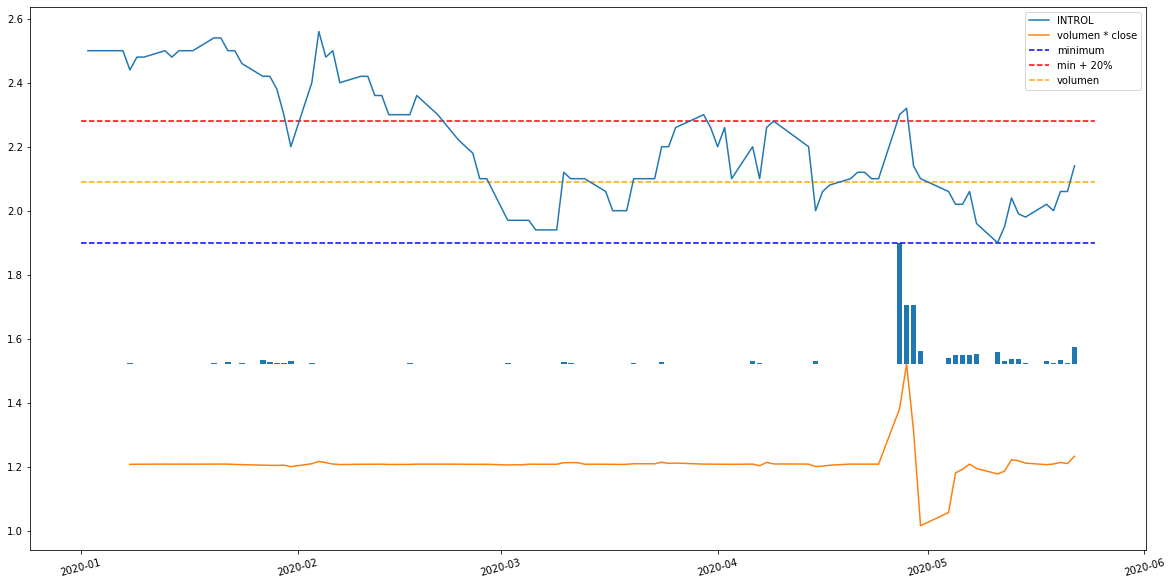

In [16]:
plot_paper(papier,'2020-01-01', str(date.today()))

In [18]:
(current,
data_max_before_crisis,
 data_crises_min,
 data_max_after_drop,
 data_min_after_max,
date_max_after_drop) = prepare_stats_forone(papier, before_crises, big_drop_date)

print(f'Paper: {papier}, currently at {current[0]}, with potential \
{round(data_max_before_crisis*100/current[0]-100, 2)}% to top')
print(f'Max before crisis: {data_max_before_crisis}')
print(f'Crisis bottom: {data_crises_min}')
print(f'Max after crisis drop: {data_max_after_drop}, at {date_max_after_drop[0]}')
print(f'Stats after Max: {data_min_after_max.values}')

Paper: INTROL, currently at 2.14, with potential 19.63% to top
Max before crisis: 2.56
Crisis bottom: 1.94
Max after crisis drop: 2.32, at 2020-04-28 00:00:00
Stats after Max: [2.32 2.14 2.1  2.06 2.02 2.02 2.06 1.96 1.9  1.95 2.04 1.99 1.98 2.02
 2.   2.06 2.06 2.14]


## Skaner

#### skaner defs

In [4]:
before_crisis = '2020-02-17'
top_bottom = '2020-03-12'
new_year = '2020-01-01'
last_y_quarter = '2019-10-01'
last_y_mid = '2019-06-03'
today = str(date.today())

df_cols = [
    'ticker', 'current', 'mean_VOL', 'before_crisis', 'last_y_q', 'last_y_mid',
    'crisis_bottom', 'max_after_crisis', 'max_before_crisis'
]

### All papers

In [5]:
skaner_df = pd.DataFrame(columns=df_cols)
for w in tqdm(all_stocks):
    
    df = prepare_data(w)
   
    skaner_df = pd.concat([skaner_df,
                       pd.DataFrame([[
                    df.TICKER[0],
                    df.loc[:,'CLOSE'].tail(1).values[0],
                    df.loc[df.index > '2019-10-01' ,'VOL'].mean(),
                    df.loc[df.index == before_crisis ,'CLOSE'].max(),
                    df.loc[df.index == last_y_quarter ,'CLOSE'].max(),
                           df.loc[df.index == last_y_mid,'CLOSE'].max(),
                    df.loc[(df.index >= top_bottom) & (df.index <= today),'CLOSE'].min(),
                    df.loc[df.index > top_bottom ,'CLOSE'].max(),
                    df.loc[(df.index >= last_y_quarter) & (df.index <= before_crisis),'CLOSE'].max()
                    
                       ]],
                                    columns=df_cols)], axis = 0)

skaner_df.loc[:,'growth_quarter'] = round(skaner_df.loc[:,'before_crisis'] * 100 / skaner_df.loc[:,'last_y_q'] - 100, 2)
skaner_df.loc[:,'growth_mid'] = round(skaner_df.loc[:,'last_y_q'] * 100 / skaner_df.loc[:,'last_y_mid'] - 100, 2)
skaner_df.loc[:,'growth_from_crisis'] = round(skaner_df.loc[:,'max_after_crisis'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_potential'] = round((skaner_df.loc[:,'max_before_crisis'] * 100) / skaner_df.loc[:,'current'] - 100, 2)
skaner_df.loc[:,'drop_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'max_before_crisis'] - 100, 2)

skaner_df = skaner_df.loc[
    skaner_df.ticker.apply(lambda x: 
                               False if ('RCFL' in x) 
                               | ('INTLGLD' in x) 
                               | ('RCFS' in x)
                               | ('INTL' in x)
                               | ('INTS' in x)
                               | ('RCTL' in x)
                               | ('BETA' in x)
                               | ('DVP' in x)
                               | ('RCT' in x)
                               | ('RCS' in x)
                               | ('RCR' in x)
                               | ('RCB' in x)
                               | ('PBSK' in x)
                               | ('RCL' in x) else True).values,]

100%|██████████| 2460/2460 [00:24<00:00, 100.85it/s]


In [6]:
skaner_df_see = skaner_df.loc[
    #(skaner_df.growth_quarter > 0) 
        #& (skaner_df.growth_mid > 0) 
        #& (skaner_df.drop_current < 0) 
        #(skaner_df.growth_current > -100)
    (skaner_df.mean_VOL > 50000)
                              ,:].sort_values('drop_current', ascending=True)

print(skaner_df_see.dropna().shape)

skaner_df_see = skaner_df_see.dropna().copy()

(133, 15)


## Model

In [60]:
### ADD WIG20 DAY BEFORE!

def transform_one_paper_ch(df):
    
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'chng_' + col] = np.nan
        df.loc[:,'chng_' + col] = (df.loc[:,col] * 100 / df.loc[:,col + '_shifted']) - 100
        
    df.loc[:,'move_strength_abs'] =  abs(df.loc[:,'chng_CLOSE']) * abs(df.loc[:,'chng_VOL'])
    df.loc[:,'move_strength'] =  (df.loc[:,'chng_CLOSE']) * (df.loc[:,'chng_VOL'])
    
    
### COMPARISON SECTION
#are you on losing strike?
#str strike
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        for i in [5, 10, 20, 30, 60, 120, 240]:
            df.loc[:,f'comp{i}d_max' + col] = df.loc[:,col].rolling(i).max()
            df.loc[:,f'comp{i}d_max' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_max' + col]) - 100
            
            df.loc[:,f'comp{i}d_min' + col] = df.loc[:,col].rolling(i).min()
            df.loc[:,f'comp{i}d_min' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_min' + col]) - 100
            
            df.loc[:,f'comp{i}d_mean' + col] = df.loc[:,col].rolling(i).mean()
            df.loc[:,f'comp{i}d_mean' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_mean' + col]) - 100
            
            df.loc[:,f'comp{i}d_std' + col] = df.loc[:,col].rolling(i).std()
            df.loc[:,f'comp{i}d_std' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_std' + col]) - 100
            
    
#     for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
#         cols = [f'comp{i}d_max' + col for i in [5,10,20]]
#         #df.loc[:,'all_higher_f'] = (df[cols] > 0).sum(axis = 1)
#         df.loc[:,'all_higher_cat'] = (df[cols] > 0).astype(str).sum(axis = 1)
        
#         cols = [f'comp{i}d_min' + col for i in [5,10,20]]
#         #df.loc[:,'all_lower_f'] = (df[cols] < 0).sum(axis = 1)
#         df.loc[:,'all_lower_cat'] = (df[cols] < 0).astype(str).sum(axis = 1)
    
            
### FUTURE SECTION ###

#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'fut_CLOSE_OPEN1'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'fut_CLOSE_OPEN1'] = 0
    
    #df.loc[:, 'fut_OPEN_CLOSE_chng'] = (df.loc[:, 'OPEN'].shift(-1) * 100 / df.loc[:, 'CLOSE']) - 100
    
#     df.loc[:, 'chng_rel_OPEN'] = np.nan
#     df.loc[df.loc[:, 'HIGH'] > df.loc[:, 'OPEN'] * 1.01,'chng_rel_OPEN'] = 1
#     df.loc[df.loc[:, 'HIGH'] <= df.loc[:, 'OPEN'] * 1.01, 'chng_rel_OPEN'] = 0
    
#     df.loc[df.loc[:, 'OPEN'] < df.loc[:, 'HIGH'],'comp_HIGH_OPEN'] = 1
#     df.loc[df.loc[:, 'OPEN'] >= df.loc[:, 'HIGH'],'comp_HIGH_OPEN'] = 0


### DIFFS SECTION ###
    df.loc[:,'diff_LOW_HIGH'] = (df.loc[:,'HIGH'] - df.loc[:,'LOW']) / df.loc[:,'HIGH']
    df.loc[:,'diff_OPEN_CLOSE'] = (df.loc[:,'OPEN'] - df.loc[:,'CLOSE']) / df.loc[:,'CLOSE']
    df.loc[:,'diff_LOW_CLOSE'] = (df.loc[:,'CLOSE'] - df.loc[:,'LOW']) / df.loc[:,'CLOSE']
    df.loc[:,'diff_HIGH_CLOSE'] = (df.loc[:,'HIGH'] - df.loc[:,'CLOSE']) / df.loc[:,'CLOSE']
    
    
### HISTORIC SECTION ###

    for a in [c for c in df.columns if ('diff_' in c) | ('chng' in c) | ('chng_' in c)]:
        for i in [1, 2, 3]:
            df.loc[:,f'hist{i}_' + a] = df.loc[:,a].shift(i)

### GET SOME MEANS ###
#Trye min and maxes and some std?
    for b in [c for c in df.columns if (('chng_' in c) 
                                        | ('move_' in c) 
                                        | ('diff_' in c)
                                       | ('same_' in c)) & ('hist' not in c)]:
        for g in [2, 3, 5, 10, 20, 40, 80, 120, 240]:
            df.loc[:,f'roll{g}m_' + b] = df.loc[:,b].rolling(g).mean()
            df.loc[:,f'roll{g}min_' + b] = df.loc[:,b].rolling(g).min()
            df.loc[:,f'roll{g}max_' + b] = df.loc[:,b].rolling(g).max()
            df.loc[:,f'roll{g}std_' + b] = df.loc[:,b].rolling(g).std()


### SUBTARGET ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'subtarget'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'subtarget'] = 0
            
### TARGET SECTION ###
#pick one the of the available sections

## HIGHER HIGH ###
#     df.loc[df.loc[:, 'HIGH'].shift(-1) > df.loc[:, 'HIGH'],'target'] = 1
#     df.loc[df.loc[:, 'HIGH'].shift(-1) <= df.loc[:, 'HIGH'],'target'] = 0

### LOWER LOW ###
#     df.loc[df.loc[:, 'LOW'].shift(-1) < df.loc[:, 'LOW'],'target'] = 1
#     df.loc[df.loc[:, 'LOW'].shift(-1) >= df.loc[:, 'LOW'],'target'] = 0
    
### HIGHER OPENING ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'target'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'target'] = 0
    
# ### HIGHER CLOSING THAN OPENING ###
#     df.loc[df.loc[:, 'CLOSE'].shift(-1) > df.loc[:, 'OPEN'].shift(-1),'target'] = 1
#     df.loc[df.loc[:, 'CLOSE'].shift(-1) <= df.loc[:, 'OPEN'].shift(-1),'target'] = 0

### OPENING NOT FAR FROM LOW ###
    df.loc[df.loc[:, 'OPEN'].shift(-1)*0.99 > df.loc[:, 'LOW'].shift(-1),'target'] = 0
    df.loc[df.loc[:, 'OPEN'].shift(-1)*0.99 <= df.loc[:, 'LOW'].shift(-1),'target'] = 1
    
### HIGH HIGHER MORE THAN 1% THAN OPENING ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1)*1.01 < df.loc[:, 'HIGH'].shift(-1),'target'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1)*1.01 >=  df.loc[:, 'HIGH'].shift(-1),'target'] = 0
    
# ### HIGHER CLOSING THAN OPENING ###

    df.loc[:, 'max_3d'] = df.loc[:, 'CLOSE'].rolling(3).max()
    df.loc[df.loc[:, 'max_3d'].shift(-3) > df.loc[:, 'OPEN'].shift(-1)*1.05,'target'] = 1
    df.loc[df.loc[:, 'max_3d'].shift(-3) <= df.loc[:, 'OPEN'].shift(-1)*1.05,'target'] = 0
    
#     df.loc[:, 'max_1d'] = df.loc[:, 'HIGH'].rolling(1).max()
#     df.loc[df.loc[:, 'max_1d'].shift(-1) > df.loc[:, 'OPEN'].shift(-1)*1.03,'target'] = 1
#     df.loc[df.loc[:, 'max_1d'].shift(-1) <= df.loc[:, 'OPEN'].shift(-1)*1.03,'target'] = 0
    
    return df
#ADD INDEX MEANS!
def transform_one_index(df):
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'chng_' + col] = np.nan
        df.loc[:,'chng_' + col] = (df.loc[:,col] * 100 / df.loc[:,col + '_shifted']) - 100
    
#     for b in ['chng_OPEN', 'chng_LOW', 'chng_HIGH', 'chng_CLOSE', 'chng_VOL']:    
#         for g in [2, 3, 5, 10, 20, 40, 80, 120, 240]:
#             df.loc[:,f'idxroll{g}m_' + b] = df.loc[:,b].rolling(g).mean()
#             df.loc[:,f'idxroll{g}min_' + b] = df.loc[:,b].rolling(g).min()
#             df.loc[:,f'idxroll{g}max_' + b] = df.loc[:,b].rolling(g).max()
#             df.loc[:,f'idxroll{g}std_' + b] = df.loc[:,b].rolling(g).std()
    return df

In [61]:
#(df_merged.OPEN < df_merged.LOW).sum()

In [62]:
def f(q, res):
    while not (q.empty()):
        pap = q.get()
        df = prepare_data(pap)
        df = transform_one_paper_ch(df) 
        df = df.dropna()
        res.put(df)
    #print('done')
    
    
def put_res_together(resfin, res):
    
    while not (res.empty()):
        df_tofin = pd.DataFrame()
        #print(res.qsize())
        for i in range(10):
            try:
                df_one = res.get()
                df_tofin = pd.concat([df_tofin, df_one])
            except:
                resfin.put(df_tofin)
                break
        resfin.put(df_tofin)    
    #print('done')

In [64]:
q = Queue()
res = Queue()
resfin = Queue()

papers_to_train = list(watch + list(skaner_df_see.dropna().ticker.values))
papers_to_train = list(dict.fromkeys(papers_to_train ))

for w in (papers_to_train):
    q.put(w)

full_size = q.qsize()
total = q.qsize()
pbar = tqdm(total = total)

p = Process(target=f, args=(q, res))
p2 = Process(target=f, args=(q, res))
p3 = Process(target=f, args=(q, res))
p4 = Process(target=f, args=(q, res))
#p5 = Process(target=f, args=(q, res))
p.start()
p2.start()
p3.start()
p4.start()
#p5.start()

pbar.update(2)
while (res.qsize() != full_size):
    if total > q.qsize():
        pbar.update(1)
        total = q.qsize()
pbar.close()

100%|██████████| 144/144 [02:38<00:00,  1.10s/it]


In [65]:
pt = Process(target=put_res_together, args=(resfin, res))
pt2 = Process(target=put_res_together, args=(resfin, res))
pt3 = Process(target=put_res_together, args=(resfin, res))
pt4 = Process(target=put_res_together, args=(resfin, res))
pt.start()
pt2.start()
pt3.start()
pt4.start()

total = res.qsize()
pbar = tqdm(total = total)

pbar.update(1)
while(res.qsize()):
    if total > res.qsize():
        pbar.update(1)
        total = res.qsize()
pbar.close()

100%|██████████| 142/142 [00:05<00:00, 27.13it/s]


In [66]:
df_papers = pd.DataFrame()

total = resfin.qsize()
pbar = tqdm(total = total)

while not resfin.empty():
    df = resfin.get()
    df_papers = pd.concat([df_papers , df])
    pbar.update(1)
pbar.close()

100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


In [67]:
p.terminate()
p2.terminate()
p3.terminate()
p4.terminate()
#p5.terminate()

pt.terminate()
pt2.terminate()
pt3.terminate()
pt4.terminate()


gc.collect()

8189

In [68]:
df_indexes = pd.DataFrame()

for p in tqdm(all_indekses):
    
    df = prepare_index(p)
    df = transform_one_index(df) 
    
    #df = df.dropna()
    
    df_indexes = pd.concat([df_indexes, df])
    del df

100%|██████████| 23/23 [00:00<00:00, 29.06it/s]


In [69]:
df_indexes = df_indexes.reset_index().groupby('DTYYYYMMDD')[['OPEN', 'HIGH', 'CLOSE']].agg(['mean', 'max', 'std']).dropna(how = 'all',axis = 1)
df_indexes.columns = 'foreign_stocks_' + df_indexes.columns.get_level_values(1) + '_chng_' + df_indexes.columns.get_level_values(0)
df_indexes = df_indexes.dropna(how = 'all',axis = 1)

In [70]:
df_merged = df_papers.merge(df_indexes, left_index=True, right_index=True, how = 'left')

train_cols = [c for c in df_merged.columns if ('chng' in c) | ('move' in c) 
              | ('comp' in c) | ('fut' in c) | ('diff' in c) | ('same' in c) | ('hist' in c)]

In [71]:
valid = df_merged.loc[df_merged.index >= '2020-04-01'].copy()

df_merged = df_merged.loc[df_merged.index < '2020-04-01']

cut_date = '2019-11-01'
train_data = df_merged.loc[df_merged.index < cut_date,train_cols]
eval_data = df_merged.loc[df_merged.index >= cut_date,train_cols]
train_labels = df_merged.loc[df_merged.index < cut_date,'target'].values
eval_labels = df_merged.loc[df_merged.index >= cut_date,'target'].values

In [72]:
def get_model():
    # Initialize CatBoostClassifier
    model = CatBoostClassifier(iterations=10000,
                           learning_rate=0.02,
                               #bagging_temperature=3,
                               #random_strength = 3,
                               use_best_model=True,
                               min_data_in_leaf=200,
                               #sampling_frequency=1,
                               #subsample = 0.8,
                           depth=5,
                               has_time=True,
                          thread_count=4,
                          eval_metric='AUC',
                          task_type='CPU')
    return model

### Train

In [73]:
model = get_model()

model.fit(train_data, train_labels, #cat_features=[0, 1],
          #eval_set=[(train_data[:-1], train_labels[:-1]),(eval_data[:-1], eval_labels[:-1])],
          eval_set=[(eval_data, eval_labels)],
         early_stopping_rounds=100, use_best_model=True)

0:	test: 0.7168455	best: 0.7168455 (0)	total: 225ms	remaining: 37m 29s
1:	test: 0.7341642	best: 0.7341642 (1)	total: 417ms	remaining: 34m 46s
2:	test: 0.7419863	best: 0.7419863 (2)	total: 654ms	remaining: 36m 19s
3:	test: 0.7445496	best: 0.7445496 (3)	total: 868ms	remaining: 36m 7s
4:	test: 0.7452036	best: 0.7452036 (4)	total: 1.09s	remaining: 36m 19s
5:	test: 0.7445859	best: 0.7452036 (4)	total: 1.33s	remaining: 36m 56s
6:	test: 0.7456669	best: 0.7456669 (6)	total: 1.55s	remaining: 36m 48s
7:	test: 0.7470026	best: 0.7470026 (7)	total: 1.77s	remaining: 36m 55s
8:	test: 0.7477163	best: 0.7477163 (8)	total: 2.02s	remaining: 37m 27s
9:	test: 0.7487627	best: 0.7487627 (9)	total: 2.24s	remaining: 37m 15s
10:	test: 0.7489631	best: 0.7489631 (10)	total: 2.42s	remaining: 36m 37s
11:	test: 0.7489973	best: 0.7489973 (11)	total: 2.67s	remaining: 37m 5s
12:	test: 0.7481226	best: 0.7489973 (11)	total: 2.96s	remaining: 37m 51s
13:	test: 0.7478708	best: 0.7489973 (11)	total: 3.21s	remaining: 38m 13s


113:	test: 0.7595248	best: 0.7595248 (113)	total: 26s	remaining: 37m 37s
114:	test: 0.7595698	best: 0.7595698 (114)	total: 26.3s	remaining: 37m 37s
115:	test: 0.7595818	best: 0.7595818 (115)	total: 26.5s	remaining: 37m 41s
116:	test: 0.7595527	best: 0.7595818 (115)	total: 26.8s	remaining: 37m 42s
117:	test: 0.7595555	best: 0.7595818 (115)	total: 27.1s	remaining: 37m 45s
118:	test: 0.7596197	best: 0.7596197 (118)	total: 27.3s	remaining: 37m 45s
119:	test: 0.7596676	best: 0.7596676 (119)	total: 27.5s	remaining: 37m 46s
120:	test: 0.7597220	best: 0.7597220 (120)	total: 27.8s	remaining: 37m 46s
121:	test: 0.7597477	best: 0.7597477 (121)	total: 28s	remaining: 37m 44s
122:	test: 0.7597877	best: 0.7597877 (122)	total: 28.2s	remaining: 37m 44s
123:	test: 0.7598457	best: 0.7598457 (123)	total: 28.4s	remaining: 37m 44s
124:	test: 0.7599093	best: 0.7599093 (124)	total: 28.7s	remaining: 37m 46s
125:	test: 0.7598991	best: 0.7599093 (124)	total: 28.9s	remaining: 37m 46s
126:	test: 0.7599390	best: 0.

223:	test: 0.7615398	best: 0.7615670 (222)	total: 51.6s	remaining: 37m 32s
224:	test: 0.7615455	best: 0.7615670 (222)	total: 51.9s	remaining: 37m 35s
225:	test: 0.7615618	best: 0.7615670 (222)	total: 52.2s	remaining: 37m 38s
226:	test: 0.7615945	best: 0.7615945 (226)	total: 52.5s	remaining: 37m 39s
227:	test: 0.7616083	best: 0.7616083 (227)	total: 52.7s	remaining: 37m 39s
228:	test: 0.7616615	best: 0.7616615 (228)	total: 53s	remaining: 37m 40s
229:	test: 0.7616687	best: 0.7616687 (229)	total: 53.2s	remaining: 37m 39s
230:	test: 0.7616756	best: 0.7616756 (230)	total: 53.4s	remaining: 37m 37s
231:	test: 0.7616651	best: 0.7616756 (230)	total: 53.6s	remaining: 37m 36s
232:	test: 0.7616564	best: 0.7616756 (230)	total: 53.9s	remaining: 37m 37s
233:	test: 0.7617329	best: 0.7617329 (233)	total: 54.1s	remaining: 37m 36s
234:	test: 0.7617403	best: 0.7617403 (234)	total: 54.3s	remaining: 37m 38s
235:	test: 0.7617138	best: 0.7617403 (234)	total: 54.6s	remaining: 37m 37s
236:	test: 0.7617128	best: 

333:	test: 0.7629080	best: 0.7630440 (322)	total: 1m 17s	remaining: 37m 19s
334:	test: 0.7628916	best: 0.7630440 (322)	total: 1m 17s	remaining: 37m 18s
335:	test: 0.7628966	best: 0.7630440 (322)	total: 1m 17s	remaining: 37m 18s
336:	test: 0.7629976	best: 0.7630440 (322)	total: 1m 18s	remaining: 37m 17s
337:	test: 0.7630033	best: 0.7630440 (322)	total: 1m 18s	remaining: 37m 18s
338:	test: 0.7630356	best: 0.7630440 (322)	total: 1m 18s	remaining: 37m 18s
339:	test: 0.7630666	best: 0.7630666 (339)	total: 1m 18s	remaining: 37m 18s
340:	test: 0.7630654	best: 0.7630666 (339)	total: 1m 18s	remaining: 37m 17s
341:	test: 0.7630672	best: 0.7630672 (341)	total: 1m 19s	remaining: 37m 15s
342:	test: 0.7630836	best: 0.7630836 (342)	total: 1m 19s	remaining: 37m 15s
343:	test: 0.7630993	best: 0.7630993 (343)	total: 1m 19s	remaining: 37m 16s
344:	test: 0.7630897	best: 0.7630993 (343)	total: 1m 19s	remaining: 37m 14s
345:	test: 0.7631246	best: 0.7631246 (345)	total: 1m 20s	remaining: 37m 15s
346:	test: 0

442:	test: 0.7641699	best: 0.7641699 (442)	total: 1m 41s	remaining: 36m 37s
443:	test: 0.7641836	best: 0.7641836 (443)	total: 1m 42s	remaining: 36m 37s
444:	test: 0.7642171	best: 0.7642171 (444)	total: 1m 42s	remaining: 36m 38s
445:	test: 0.7642173	best: 0.7642173 (445)	total: 1m 42s	remaining: 36m 38s
446:	test: 0.7642061	best: 0.7642173 (445)	total: 1m 42s	remaining: 36m 36s
447:	test: 0.7641998	best: 0.7642173 (445)	total: 1m 43s	remaining: 36m 36s
448:	test: 0.7642200	best: 0.7642200 (448)	total: 1m 43s	remaining: 36m 35s
449:	test: 0.7642597	best: 0.7642597 (449)	total: 1m 43s	remaining: 36m 34s
450:	test: 0.7642609	best: 0.7642609 (450)	total: 1m 43s	remaining: 36m 33s
451:	test: 0.7642794	best: 0.7642794 (451)	total: 1m 43s	remaining: 36m 34s
452:	test: 0.7643474	best: 0.7643474 (452)	total: 1m 44s	remaining: 36m 34s
453:	test: 0.7643646	best: 0.7643646 (453)	total: 1m 44s	remaining: 36m 34s
454:	test: 0.7643496	best: 0.7643646 (453)	total: 1m 44s	remaining: 36m 33s
455:	test: 0

552:	test: 0.7651946	best: 0.7651965 (551)	total: 2m 6s	remaining: 36m 8s
553:	test: 0.7651881	best: 0.7651965 (551)	total: 2m 7s	remaining: 36m 8s
554:	test: 0.7651844	best: 0.7651965 (551)	total: 2m 7s	remaining: 36m 7s
555:	test: 0.7651968	best: 0.7651968 (555)	total: 2m 7s	remaining: 36m 6s
556:	test: 0.7651934	best: 0.7651968 (555)	total: 2m 7s	remaining: 36m 6s
557:	test: 0.7651927	best: 0.7651968 (555)	total: 2m 8s	remaining: 36m 6s
558:	test: 0.7652122	best: 0.7652122 (558)	total: 2m 8s	remaining: 36m 6s
559:	test: 0.7652425	best: 0.7652425 (559)	total: 2m 8s	remaining: 36m 6s
560:	test: 0.7652595	best: 0.7652595 (560)	total: 2m 8s	remaining: 36m 5s
561:	test: 0.7652188	best: 0.7652595 (560)	total: 2m 8s	remaining: 36m 5s
562:	test: 0.7651786	best: 0.7652595 (560)	total: 2m 9s	remaining: 36m 5s
563:	test: 0.7651776	best: 0.7652595 (560)	total: 2m 9s	remaining: 36m 5s
564:	test: 0.7651860	best: 0.7652595 (560)	total: 2m 9s	remaining: 36m 5s
565:	test: 0.7651820	best: 0.7652595 (

661:	test: 0.7651590	best: 0.7652874 (629)	total: 2m 31s	remaining: 35m 31s
662:	test: 0.7651549	best: 0.7652874 (629)	total: 2m 31s	remaining: 35m 31s
663:	test: 0.7651036	best: 0.7652874 (629)	total: 2m 31s	remaining: 35m 30s
664:	test: 0.7650733	best: 0.7652874 (629)	total: 2m 31s	remaining: 35m 29s
665:	test: 0.7650822	best: 0.7652874 (629)	total: 2m 31s	remaining: 35m 29s
666:	test: 0.7650781	best: 0.7652874 (629)	total: 2m 32s	remaining: 35m 28s
667:	test: 0.7650861	best: 0.7652874 (629)	total: 2m 32s	remaining: 35m 27s
668:	test: 0.7651137	best: 0.7652874 (629)	total: 2m 32s	remaining: 35m 27s
669:	test: 0.7651338	best: 0.7652874 (629)	total: 2m 32s	remaining: 35m 27s
670:	test: 0.7651280	best: 0.7652874 (629)	total: 2m 33s	remaining: 35m 27s
671:	test: 0.7650710	best: 0.7652874 (629)	total: 2m 33s	remaining: 35m 27s
672:	test: 0.7650542	best: 0.7652874 (629)	total: 2m 33s	remaining: 35m 27s
673:	test: 0.7650466	best: 0.7652874 (629)	total: 2m 33s	remaining: 35m 27s
674:	test: 0

In [74]:
model.get_feature_importance(prettified=True).head(12)

,Feature Id,Importances
0,roll240std_chng_HIGH,3.342254
1,roll120m_move_strength_abs,2.625151
2,roll240std_chng_OPEN,2.607722
3,roll120std_diff_OPEN_CLOSE,2.584898
4,roll40std_chng_OPEN,2.148737
5,roll240std_chng_CLOSE,1.838883
6,roll40max_diff_HIGH_CLOSE,1.727699
7,roll80std_move_strength,1.412417
8,roll40m_move_strength_abs,1.158285
9,roll120std_chng_LOW,1.131692


In [75]:
working_feats_785_on_high = ['diff_HIGH_CLOSE', 'diff_OPEN_CLOSE','roll20min_diff_LOW_HIGH',
                     'chng_HIGH','roll2std_chng_HIGH',
                     'comp5d_stdHIGH','roll20min_chng_VOL','comp5d_meanOPEN','move_strength_abs',
                     'roll2min_chng_HIGH','roll3min_move_strength_abs']

imp = model.get_feature_importance(prettified=True)
train_cols_limited  = [c for c in train_cols if c in imp.loc[imp.Importances >= 0.01, 'Feature Id'].values]
#train_cols_limited = working_feats_785_on_high
len(train_cols) - len(train_cols_limited)

112

### Check eval

In [76]:
preds_class = model.predict(eval_data)
# Get predicted probabilities for each class
preds_proba = model.predict_proba(eval_data)
# Get predicted RawFormulaVal
preds_raw = model.predict(eval_data, prediction_type='RawFormulaVal')

preds = preds_class[:-1].astype(int)

In [77]:
preds = preds_proba[:,1].copy()

preds[preds > 0.5] = 1
preds[preds < 1] = 0
preds = preds[:-1].astype(int)

In [78]:
tn, fp, fn, tp = confusion_matrix(eval_labels[:-1].astype(int), preds).ravel()
(tn, fp, fn, tp)

(9924, 157, 2153, 196)

In [79]:
(tn + tp) / (tn + tp + fp + fn)

0.8141592920353983

In [80]:
tp / (tp + fp)

0.5552407932011332

In [81]:
df_res = pd.concat([pd.DataFrame(preds_proba), pd.Series(eval_labels)], axis=1)
df_res.columns = ['zero', 'one', 'true']
df_res.groupby('true').mean()

,zero,one
true,,
0.0,0.842498,0.157502
1.0,0.704698,0.295302


In [82]:
df_res.loc[:,'one'] = df_res.loc[:,'one'].round(1)
df_res.loc[:,'zero'] = df_res.loc[:,'zero'].round(2)
df_res_grouped = df_res.drop('zero', axis = 1)

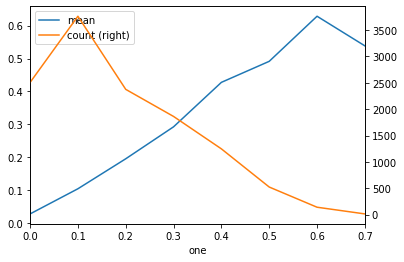

In [83]:
# df_res_grouped.loc[df_res_grouped.one <= 0.3,'one'] = 0.3
# df_res_grouped.loc[df_res_grouped.one >= 0.54,'one'] = 0.55
df_res_grouped = df_res_grouped.groupby('one').agg(['mean', 'count'])
df_res_grouped.columns = df_res_grouped.columns.get_level_values(1)
df_res_grouped = df_res_grouped.reset_index().set_index('one')

df_res_grouped.plot(secondary_y='count')
plt.xticks(rotation=60)
plt.show()

In [84]:
df_res_grouped

,mean,count
one,,
0.0,0.027124,2507
0.1,0.103641,3763
0.2,0.194865,2376
0.3,0.292159,1862
0.4,0.427426,1247
0.5,0.491396,523
0.6,0.628571,140
0.7,0.538462,13


### Check valid

In [85]:
valid_data = valid.loc[:,train_cols]
valid_labels = valid.loc[:,'target'].values

preds_class = model.predict(valid_data)
# Get predicted probabilities for each class

preds = preds_class[:-1].astype(int)

In [86]:
preds_proba = model.predict_proba(valid_data)

preds = preds_proba[:,1].copy()

preds[preds > 0.5] = 1
preds[preds < 1] = 0
preds = preds[:-1].astype(int)

In [87]:
tn, fp, fn, tp = confusion_matrix(valid_labels[:-1].astype(int), preds).ravel()
(tn, fp, fn, tp)

(3487, 20, 1322, 27)

In [88]:
(tn + tp) / (tn + tp + fp + fn)

0.7236408566721582

In [89]:
tp / (tp + fp)

0.574468085106383

In [90]:
(tp / preds.shape[0]) * 100

0.556013179571664

### Prediction

In [91]:
def transform_results(qpapers, qtransformed, model):
    while not (qpapers.empty()):
        pap = qpapers.get()
        #print(pap)
        df = prepare_data(pap)
        df = transform_one_paper_ch(df) 
        
        df = df.merge(df_indexes,
              left_index=True,
              right_index=True,
              how='left')

        #df.loc[:, 'pred_class'] = model.predict(df[train_cols])
        df.loc[:, 'pred_prob'] = model.predict_proba(df[train_cols])[:, 1]

        df.loc[:, 'fut_OPEN'] = df.loc[:, 'OPEN'].shift(-1)
        df.loc[:, 'fut_CLOSE'] = df.loc[:, 'CLOSE'].shift(-1)
        df.loc[:, 'fut_LOW'] = df.loc[:, 'LOW'].shift(-1)
        df.loc[:, 'fut_HIGH'] = df.loc[:, 'HIGH'].shift(-1)
        
        df.loc[:, 'fut5_CLOSE'] = df.loc[:, 'CLOSE'].shift(-5)
        df.loc[:, 'max_5d'] = df.loc[:, 'CLOSE'].rolling(5).max()
        
        df.loc[:, 'fut10_CLOSE'] = df.loc[:, 'CLOSE'].shift(-10)
        df.loc[:, 'max_10d'] = df.loc[:, 'CLOSE'].rolling(10).max()
        
        df.loc[:, 'fOPEN_fHIGH_chng'] = (df.loc[:, 'fut_HIGH'] * 100 /
                                 df.loc[:, 'fut_OPEN']) - 100
        df.loc[:, 'fOPEN_fCLOSE_chng'] = (df.loc[:, 'fut_CLOSE'] * 100 /
                                 df.loc[:, 'fut_OPEN']) - 100
        df.loc[:, 'CLOSE_fOPEN_chng'] = (df.loc[:, 'fut_OPEN'] * 100 /
                                         df.loc[:, 'CLOSE']) - 100
        df.loc[:, 'HIGH_fHIGH_chng'] = (df.loc[:, 'fut_HIGH'] * 100 /
                         df.loc[:, 'HIGH']) - 100
        df.loc[:, 'LOW_fLOW_chng'] = (df.loc[:, 'fut_LOW'] * 100 /
                 df.loc[:, 'LOW']) - 100
        
        df.loc[:, 'fOPEN_f10CLOSE_chng'] = (df.loc[:, 'fut10_CLOSE'] * 100 /
             df.loc[:, 'fut_OPEN']) - 100
        
        df.loc[:, 'fOPEN_f10MAX_chng'] = (df.loc[:, 'max_10d'].shift(-10) * 100 /
             df.loc[:, 'fut_OPEN']) - 100
        
        df.loc[:, 'fOPEN_f5CLOSE_chng'] = (df.loc[:, 'fut5_CLOSE'] * 100 /
             df.loc[:, 'fut_OPEN']) - 100
        
        df.loc[:, 'fOPEN_f5MAX_chng'] = (df.loc[:, 'max_5d'].shift(-5) * 100 /
             df.loc[:, 'fut_OPEN']) - 100
    

        one_res = df.reset_index().loc[:, [
            'DTYYYYMMDD', 'TICKER', 'OPEN', 'LOW', 'HIGH', 'CLOSE', 
           'fut_OPEN', 'fut_LOW', 'fut_HIGH', 'fut_CLOSE', 'fOPEN_fHIGH_chng', 
            'fOPEN_fCLOSE_chng', 'CLOSE_fOPEN_chng', 'HIGH_fHIGH_chng', 'LOW_fLOW_chng', 
            'fOPEN_f5CLOSE_chng', 'fOPEN_f5MAX_chng',
            'fOPEN_f10CLOSE_chng', 'fOPEN_f10MAX_chng', 'pred_prob']
                                      ].tail(30)
    
        #if one_res.shape == (15, 16):
        qtransformed.put(one_res)
    
    
def put_res_results_together(resfin, res):
    
    while not (res.empty()):
        df_tofin = pd.DataFrame()
        #print(res.qsize())
        for i in range(10):
            try:
                df_one = res.get()
                df_tofin = pd.concat([df_tofin, df_one])
            except:
                resfin.put(df_tofin)
                break
        resfin.put(df_tofin)    
    #print('done')

In [92]:
qpapers = Queue()
qtransformed = Queue()

for w in (skaner_df_see.dropna().ticker.values):
    qpapers.put(w)

total = qpapers.qsize()
full_size = qpapers.qsize()

#%%time
p = Process(target=transform_results, args=(qpapers, qtransformed, model))
p2 = Process(target=transform_results, args=(qpapers, qtransformed, model))
p3 = Process(target=transform_results, args=(qpapers, qtransformed, model))
p4 = Process(target=transform_results, args=(qpapers, qtransformed, model))
#p5 = Process(target=transform_results, args=(qpapers, qtransformed, model))
p.start()
p2.start()
p3.start()
p4.start()
#p5.start()


pbar = tqdm(total = total)

while not qpapers.empty():
    if total > qpapers.qsize():
        pbar.update(1)
        #print(total)
        total = qpapers.qsize()
pbar.close()

 96%|█████████▌| 128/133 [02:38<00:06,  1.24s/it]


In [93]:
qtransformed.qsize()

129

In [94]:
res = pd.DataFrame()
for i in tqdm(range(qtransformed.qsize())):
    df = qtransformed.get()
    #print(df.TICKER.values[0])
    res = pd.concat([res, df])
    #print(res.shape)

100%|██████████| 129/129 [00:00<00:00, 371.95it/s]


In [95]:
p.terminate()
p2.terminate()
p3.terminate()
p4.terminate()
#p5.terminate()

### Prediction results

In [96]:
res.loc[:,'DTYYYYMMDD'] = pd.to_datetime(res.DTYYYYMMDD)

In [43]:
res.loc[res.DTYYYYMMDD == prepare_data("WIG20").index.max().strftime(format = "%Y-%m-%d")]\
.sort_values('pred_prob', ascending=False).dropna(how='all', axis = 1).head(15)

,DTYYYYMMDD,TICKER,OPEN,LOW,HIGH,CLOSE,pred_prob
868,2020-05-28,JWA,0.2700,0.2200,0.2740,0.2390,0.572784
1623,2020-05-28,TELGAM,0.7050,0.5350,0.7050,0.5700,0.523407
1082,2020-05-28,SOFTBLUE,1.4600,1.1000,1.4900,1.3400,0.517497
3344,2020-05-28,HERKULES,1.5700,1.3300,1.6600,1.4100,0.513171
411,2020-05-28,HORNIGOLD,0.2280,0.2000,0.2350,0.2100,0.496311
1885,2020-05-28,MBFGROUP,3.9000,3.8400,4.1000,3.8600,0.457134
1171,2020-05-28,IGORIA,0.2200,0.2080,0.2400,0.2300,0.444089
815,2020-05-28,TERMO2PWR,0.2450,0.2450,0.2900,0.2780,0.409216
685,2020-05-28,BIZTECH,0.2220,0.2100,0.2380,0.2110,0.395618
1472,2020-05-28,BORUTA,0.2680,0.2460,0.2700,0.2600,0.378993


In [97]:
res.loc[res.DTYYYYMMDD == prepare_data("WIG20").index.max().strftime(format = "%Y-%m-%d")]\
.sort_values('pred_prob', ascending=False).dropna(how='all', axis = 1).head(15)

,DTYYYYMMDD,TICKER,OPEN,LOW,HIGH,CLOSE,pred_prob
868,2020-05-28,JWA,0.270,0.220,0.274,0.239,0.593196
1082,2020-05-28,SOFTBLUE,1.460,1.100,1.490,1.340,0.565398
3344,2020-05-28,HERKULES,1.570,1.330,1.660,1.410,0.524558
411,2020-05-28,HORNIGOLD,0.228,0.200,0.235,0.210,0.494624
1171,2020-05-28,IGORIA,0.220,0.208,0.240,0.230,0.462130
1885,2020-05-28,MBFGROUP,3.900,3.840,4.100,3.860,0.431804
1472,2020-05-28,BORUTA,0.268,0.246,0.270,0.260,0.417747
685,2020-05-28,BIZTECH,0.222,0.210,0.238,0.211,0.408590
815,2020-05-28,TERMO2PWR,0.245,0.245,0.290,0.278,0.395142
6494,2020-05-28,RAFAKO,1.160,1.078,1.340,1.090,0.388316


In [44]:
last_day = res.loc[res.DTYYYYMMDD == (prepare_data("WIG20").reset_index()['DTYYYYMMDD']).nlargest(2).iloc[1].strftime(format = "%Y-%m-%d")].sort_values('pred_prob', ascending=False)

In [45]:
last_day.mean().dropna()

OPEN                 1467.174028
LOW                  1438.799216
HIGH                 1492.843229
CLOSE                1448.249693
fut_OPEN             1469.046683
fut_LOW              1435.926398
fut_HIGH             1485.417425
fut_CLOSE            1459.022387
fOPEN_fHIGH_chng        2.827172
fOPEN_fCLOSE_chng      -1.186199
CLOSE_fOPEN_chng        0.997977
HIGH_fHIGH_chng        -0.408568
LOW_fLOW_chng          -0.432600
pred_prob               0.219627
dtype: float64

In [46]:
last_day.loc[last_day.pred_prob > 0.5].mean().dropna()

OPEN                  0.985000
LOW                   0.795000
HIGH                  1.040000
CLOSE                 0.836000
fut_OPEN              0.865000
fut_LOW               0.660000
fut_HIGH              0.882000
fut_CLOSE             0.789500
fOPEN_fHIGH_chng      1.768138
fOPEN_fCLOSE_chng    -9.850330
CLOSE_fOPEN_chng      1.775210
HIGH_fHIGH_chng     -12.479401
LOW_fLOW_chng       -14.955224
pred_prob             0.531395
dtype: float64

In [47]:
last_day.loc[(last_day.pred_prob > 0.5) & 
            (last_day.CLOSE_fOPEN_chng >=0),:].mean()

OPEN                    1.670000
LOW                     1.340000
HIGH                    1.780000
CLOSE                   1.400000
fut_OPEN                1.460000
fut_LOW                 1.100000
fut_HIGH                1.490000
fut_CLOSE               1.340000
fOPEN_fHIGH_chng        2.054795
fOPEN_fCLOSE_chng      -8.219178
CLOSE_fOPEN_chng        4.285714
HIGH_fHIGH_chng       -16.292135
LOW_fLOW_chng         -17.910448
fOPEN_f5CLOSE_chng           NaN
fOPEN_f5MAX_chng             NaN
fOPEN_f10CLOSE_chng          NaN
fOPEN_f10MAX_chng            NaN
pred_prob               0.524567
dtype: float64

In [48]:
last_day.loc[(last_day.pred_prob > 0.5) & 
            (last_day.CLOSE_fOPEN_chng <0),:].mean()

OPEN                    0.300000
LOW                     0.250000
HIGH                    0.300000
CLOSE                   0.272000
fut_OPEN                0.270000
fut_LOW                 0.220000
fut_HIGH                0.274000
fut_CLOSE               0.239000
fOPEN_fHIGH_chng        1.481481
fOPEN_fCLOSE_chng     -11.481481
CLOSE_fOPEN_chng       -0.735294
HIGH_fHIGH_chng        -8.666667
LOW_fLOW_chng         -12.000000
fOPEN_f5CLOSE_chng           NaN
fOPEN_f5MAX_chng             NaN
fOPEN_f10CLOSE_chng          NaN
fOPEN_f10MAX_chng            NaN
pred_prob               0.538223
dtype: float64

In [49]:
res_see = res.sort_values('pred_prob', ascending=False).copy()
res_see = res_see.drop_duplicates()

In [50]:
res_see.groupby('DTYYYYMMDD').mean().mean()

OPEN                   674.518460
LOW                    667.309810
HIGH                   681.165529
CLOSE                  674.352990
fut_OPEN               674.891793
fut_LOW                667.671644
fut_HIGH               681.686735
fut_CLOSE              674.837803
fOPEN_fHIGH_chng         4.206912
fOPEN_fCLOSE_chng       -0.016589
CLOSE_fOPEN_chng        -0.453913
HIGH_fHIGH_chng         -0.489215
LOW_fLOW_chng           -0.487587
fOPEN_f5CLOSE_chng      -4.512209
fOPEN_f5MAX_chng         4.295980
fOPEN_f10CLOSE_chng    -10.507562
fOPEN_f10MAX_chng        7.198865
pred_prob                0.297842
dtype: float64

In [52]:
res_see.loc[res_see.pred_prob > 0.5].groupby('DTYYYYMMDD').mean().mean()

OPEN                    3.051750
LOW                     2.720274
HIGH                    3.198250
CLOSE                   2.818331
fut_OPEN                2.871025
fut_LOW                 2.700275
fut_HIGH                3.163067
fut_CLOSE               2.994317
fOPEN_fHIGH_chng        8.156967
fOPEN_fCLOSE_chng       1.629725
CLOSE_fOPEN_chng       -0.899013
HIGH_fHIGH_chng        -3.775648
LOW_fLOW_chng          -3.478918
fOPEN_f5CLOSE_chng      7.738243
fOPEN_f5MAX_chng       16.255047
fOPEN_f10CLOSE_chng    23.739268
fOPEN_f10MAX_chng      40.173700
pred_prob               0.528359
dtype: float64

In [53]:
res_see.loc[(res_see.CLOSE_fOPEN_chng < 0) & 
           (res_see.pred_prob > 0.5)].groupby('DTYYYYMMDD').mean().mean()

OPEN                    2.164675
LOW                     1.978292
HIGH                    2.315583
CLOSE                   2.083600
fut_OPEN                2.017263
fut_LOW                 1.865792
fut_HIGH                2.306658
fut_CLOSE               2.156942
fOPEN_fHIGH_chng        9.140271
fOPEN_fCLOSE_chng       2.425366
CLOSE_fOPEN_chng       -4.812197
HIGH_fHIGH_chng        -3.711248
LOW_fLOW_chng          -3.717848
fOPEN_f5CLOSE_chng      8.731418
fOPEN_f5MAX_chng       16.677637
fOPEN_f10CLOSE_chng    34.863796
fOPEN_f10MAX_chng      50.045299
pred_prob               0.532308
dtype: float64

In [54]:
res_see.loc[(res_see.CLOSE_fOPEN_chng > 0) & 
           (res_see.pred_prob > 0.5)].groupby('DTYYYYMMDD').mean().mean()

OPEN                    3.026611
LOW                     2.608533
HIGH                    3.128789
CLOSE                   2.701022
fut_OPEN                2.773422
fut_LOW                 2.620678
fut_HIGH                2.972078
fut_CLOSE               2.809878
fOPEN_fHIGH_chng        5.756847
fOPEN_fCLOSE_chng      -0.725641
CLOSE_fOPEN_chng        4.902124
HIGH_fHIGH_chng        -3.829579
LOW_fLOW_chng          -2.342314
fOPEN_f5CLOSE_chng      6.487942
fOPEN_f5MAX_chng       15.058220
fOPEN_f10CLOSE_chng     9.329394
fOPEN_f10MAX_chng      26.828609
pred_prob               0.523937
dtype: float64

In [56]:
compare = res_see.loc[(res_see.pred_prob > 0.5)].groupby('DTYYYYMMDD').mean()['fOPEN_fCLOSE_chng']-res_see.groupby('DTYYYYMMDD').mean()['fOPEN_fCLOSE_chng']

In [57]:
(compare > 0).sum() / ((compare < 0).sum() + (compare > 0).sum())

0.6

## Reports

### Extract raw reports

In [174]:
reports_names = os.listdir('reports/')

In [178]:
one_rep  = pd.read_html('reports/' + reports_names[0])

In [182]:
one_rep[1].shape

(19, 39)

In [194]:
%%time
cols_extended = list()
col_counter = dict()
df_reports = pd.DataFrame()
for r in (reports_names):
    try:
        one_rep  = pd.read_html('reports/' + r)
    except Exception:
        print(r + ' Didnt go through!')
        continue
    for i in range(len(one_rep)):
        if (one_rep[i].shape[1] > 8):
            one_rep = one_rep[i]
            one_rep.columns = ['col_name'] + list(one_rep.columns[1:])
            one_rep = one_rep.set_index('col_name').transpose().reset_index()
            one_rep.loc[:, 'name'] = r
            print(one_rep.columns)
            df_reports = pd.concat([df_reports, one_rep], sort=False, axis = 0)
            if 'name' not in df_reports.columns:
                print('name not in the columns')
            #print(one_rep.columns)
            cols_extended.append(one_rep.columns)
            for c in one_rep.columns:
                if c in col_counter.keys():
                    col_counter[c] = col_counter[c] + 1
                else:
                    col_counter[c] = 0
            break

Index(['index', 'Data publikacji', 'Przychody ze sprzedaży',
       'Techniczny koszt wytworzenia produkcji sprzedanej', 'Koszty sprzedaży',
       'Koszty ogólnego zarządu', 'Zysk ze sprzedaży',
       'Pozostałe przychody operacyjne', 'Pozostałe koszty operacyjne',
       'Zysk operacyjny (EBIT)', 'Przychody finansowe', 'Koszty finansowe',
       'Pozostałe przychody (koszty)', 'Zysk z działalności gospodarczej',
       'Wynik zdarzeń nadzwyczajnych', 'Zysk przed opodatkowaniem',
       'Zysk (strata) netto z działalności zaniechanej', 'Zysk netto',
       'Zysk netto akcjonariuszy jednostki dominującej', 'EBITDA', 'name'],
      dtype='object', name='col_name')
Index(['index', 'Data publikacji', 'Przychody ze sprzedaży',
       'Techniczny koszt wytworzenia produkcji sprzedanej', 'Koszty sprzedaży',
       'Koszty ogólnego zarządu', 'Zysk ze sprzedaży',
       'Pozostałe przychody operacyjne', 'Pozostałe koszty operacyjne',
       'Zysk operacyjny (EBIT)', 'Przychody finansowe', 'Ko

ValueError: Plan shapes are not aligned

In [195]:
one_rep.head(2)

col_name,index,Data publikacji,Przychody odsetkowe,Przychody odsetkowe,Koszty odsetkowe,Wynik z tytułu odsetek,Przychody prowizyjne,Koszty prowizyjne,Wynik z tytułu prowizji,Przychody z tytułu dywidend,...,Ogólne koszty administracyjne,Pozostałe koszty operacyjne,Wynik operacyjny,Udział w zyskach jednostek podporządkowanych,Zysk przed opodatkowaniem,Zysk (strata) netto z działalności zaniechanej,Zysk netto,Zysk netto akcjonariuszy jednostki dominującej,EBITDA,name
0,2015/Q1 (mar 15),2015-05-07,191 425,191 425,116 954,74 471,134 432,21 084,113 348,0,...,-129 333,-4 463,62 724,1 187,63 911,0,63 133,63 023,74 296,"raporty-IDEA-BANK,Q.html"
1,2015/Q2 (cze 15),2015-07-29,177 425k/k -7.31%~sektor -4.26%,177 425k/k -7.31%~sektor -4.26%,104 545k/k -10.61%~sektor -9.24%,72 880k/k -2.14%~sektor +3.65%,158 776k/k +18.11%~sektor +4.29%,31 145k/k +47.72%~sektor +5.86%,127 631k/k +12.60%~sektor +6.80%,0,...,-133 861k/k -3.50%~sektor -3.31%,-12 654k/k -183.53%~sektor -51.52%,66 041k/k +5.29%~sektor -1.39%,5 276k/k +344.48%~sektor +102.88%,71 317k/k +11.59%~sektor -1.57%,0,117 957k/k +86.84%~sektor +1.64%,117 917k/k +87.10%~sektor -0.83%,77 688k/k +4.57%~sektor -1.10%,"raporty-IDEA-BANK,Q.html"


In [196]:
 df_reports.head(2)

col_name,index,Data publikacji,Przychody ze sprzedaży,Techniczny koszt wytworzenia produkcji sprzedanej,Koszty sprzedaży,Koszty ogólnego zarządu,Zysk ze sprzedaży,Pozostałe przychody operacyjne,Pozostałe koszty operacyjne,Zysk operacyjny (EBIT),...,Koszty finansowe,Pozostałe przychody (koszty),Zysk z działalności gospodarczej,Wynik zdarzeń nadzwyczajnych,Zysk przed opodatkowaniem,Zysk (strata) netto z działalności zaniechanej,Zysk netto,Zysk netto akcjonariuszy jednostki dominującej,EBITDA,name
0,2011/Q1 (mar 11),NaN,282 089,236 690,16 740,11 945,16 714,1 327,252,17 789,...,11 684,249,7 290,0,7 290,0,6 681,6 681,30 239,"raporty-ROKITA,Q.html"
1,2011/Q2 (cze 11),2011-08-31,120 180k/k -57.40%~sektor -6.11%,104 329k/k -55.92%~sektor -7.29%,7 965k/k -52.42%~sektor +8.14%,4 317k/k -63.86%~sektor +6.42%,3 569k/k -78.65%~sektor -16.66%,3 543k/k +166.99%~sektor +147.69%,15k/k -94.05%~sektor -21.72%,7 097k/k -60.10%~sektor -22.39%,...,-220k/k -101.88%~sektor -10.86%,-126k/k -150.60%~sektor -70.53%,7 391k/k +1.39%~sektor +1.39%,0,7 391k/k +1.39%~sektor +1.39%,2 033,9 276k/k +38.84%~sektor +2.49%,9 276k/k +38.84%~sektor -8.81%,20 119k/k -33.47%~sektor -15.70%,"raporty-ROKITA,Q.html"


In [197]:
test_cols = [c for c in one_rep if c in df_reports.columns]

In [198]:
test_cols

['index',
 'Data publikacji',
 'Pozostałe przychody operacyjne',
 'Pozostałe koszty operacyjne',
 'Zysk przed opodatkowaniem',
 'Zysk (strata) netto z działalności zaniechanej',
 'Zysk netto',
 'Zysk netto akcjonariuszy jednostki dominującej',
 'EBITDA',
 'name']

In [201]:
pd.concat([df_reports, one_rep[test_cols]], sort=True).head(2)

,Data publikacji,EBITDA,Koszty finansowe,Koszty ogólnego zarządu,Koszty sprzedaży,Pozostałe koszty operacyjne,Pozostałe przychody (koszty),Pozostałe przychody operacyjne,Przychody finansowe,Przychody ze sprzedaży,...,Wynik zdarzeń nadzwyczajnych,Zysk (strata) netto z działalności zaniechanej,Zysk netto,Zysk netto akcjonariuszy jednostki dominującej,Zysk operacyjny (EBIT),Zysk przed opodatkowaniem,Zysk z działalności gospodarczej,Zysk ze sprzedaży,index,name
0,NaN,30 239,11 684,11 945,16 740,252,249,1 327,936,282 089,...,0,0,6 681,6 681,17 789,7 290,7 290,16 714,2011/Q1 (mar 11),"raporty-ROKITA,Q.html"
1,2011-08-31,20 119k/k -33.47%~sektor -15.70%,-220k/k -101.88%~sektor -10.86%,4 317k/k -63.86%~sektor +6.42%,7 965k/k -52.42%~sektor +8.14%,15k/k -94.05%~sektor -21.72%,-126k/k -150.60%~sektor -70.53%,3 543k/k +166.99%~sektor +147.69%,200k/k -78.63%~sektor -60.23%,120 180k/k -57.40%~sektor -6.11%,...,0,2 033,9 276k/k +38.84%~sektor +2.49%,9 276k/k +38.84%~sektor -8.81%,7 097k/k -60.10%~sektor -22.39%,7 391k/k +1.39%~sektor +1.39%,7 391k/k +1.39%~sektor +1.39%,3 569k/k -78.65%~sektor -16.66%,2011/Q2 (cze 11),"raporty-ROKITA,Q.html"


### Analyze

In [170]:
all_reports = pd.read_csv('../bizcrap/fundamental_reports.csv')

In [61]:
cols_to_change = list(all_reports.columns)
cols_to_change[0] = 'Data'
all_reports.columns = cols_to_change

In [45]:
[a for a in all_reports.name.unique() if 'ORLEN' in a]

['raporty-PKN-ORLEN,Q.html']

In [55]:
cols_zysk = [c for c in all_reports.columns if 'zysk' in c]

In [53]:
for c in all_reports.columns:
    all_reports.loc[all_reports.loc[:,c]==-1,c] = np.nan

In [62]:
all_reports.head()

,Data,name,przychody_ze_sprzedaży_main,przychody_ze_sprzedaży_kk,przychody_ze_sprzedaży_sector,techniczny_koszt_wytworzenia_produkcji_sprzedanej_main,techniczny_koszt_wytworzenia_produkcji_sprzedanej_kk,techniczny_koszt_wytworzenia_produkcji_sprzedanej_sector,koszty_sprzedaży_main,koszty_sprzedaży_kk,...,odpisy_netto_z_tytułu_utraty_wartości_kredytów_sector,ogólne_koszty_administracyjne_main,ogólne_koszty_administracyjne_kk,ogólne_koszty_administracyjne_sector,wynik_operacyjny_main,wynik_operacyjny_kk,wynik_operacyjny_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
0,2011/Q1,"raporty-ROKITA,Q.html",282089.0,NaN,NaN,236690.0,NaN,NaN,16740.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011/Q2,"raporty-ROKITA,Q.html",120180.0,-57.40,-6.11,104329.0,-55.92,-7.29,7965.0,-52.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011/Q3,"raporty-ROKITA,Q.html",186398.0,55.10,11.93,163713.0,56.92,4.74,10028.0,25.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011/Q4,"raporty-ROKITA,Q.html",232250.0,24.60,24.60,184412.0,12.64,12.64,17560.0,75.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012/Q1,"raporty-ROKITA,Q.html",243002.0,4.63,-7.39,202362.0,9.73,-4.46,13294.0,-24.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
all_reports.loc[all_reports.name=='raporty-PKN-ORLEN,Q.html',['Data', 'name'] + cols_zysk]

,Data,name,zysk_ze_sprzedaży_main,zysk_ze_sprzedaży_kk,zysk_ze_sprzedaży_sector,zysk_operacyjny_(ebit)_main,zysk_operacyjny_(ebit)_kk,zysk_operacyjny_(ebit)_sector,zysk_z_działalności_gospodarczej_main,zysk_z_działalności_gospodarczej_kk,...,zysk_(strata)_netto_z_działalności_zaniechanej_sector,zysk_netto_main,zysk_netto_kk,zysk_netto_sector,zysk_netto_akcjonariuszy_jednostki_dominującej_main,zysk_netto_akcjonariuszy_jednostki_dominującej_kk,zysk_netto_akcjonariuszy_jednostki_dominującej_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
6856,2005/Q1,"raporty-PKN-ORLEN,Q.html",783503.0,NaN,NaN,797953.0,NaN,NaN,820771.0,NaN,...,NaN,678534.0,NaN,NaN,667527.0,NaN,NaN,NaN,NaN,NaN
6857,2005/Q2,"raporty-PKN-ORLEN,Q.html",1101747.0,40.62,11.69,2615077.0,227.72,9.19,2813959.0,242.84,...,NaN,2565468.0,278.09,38.03,2560212.0,283.54,28.11,NaN,NaN,NaN
6858,2005/Q3,"raporty-PKN-ORLEN,Q.html",1120514.0,1.70,37.29,1090777.0,-58.29,29.90,1221227.0,-56.60,...,NaN,994419.0,-61.24,-0.90,985238.0,-61.52,-0.04,NaN,NaN,NaN
6859,2005/Q4,"raporty-PKN-ORLEN,Q.html",673032.0,-39.94,-24.82,443813.0,-59.31,-34.51,417113.0,-65.84,...,NaN,399355.0,-59.84,-1.46,365479.0,-62.90,-3.24,NaN,NaN,NaN
6860,2006/Q1,"raporty-PKN-ORLEN,Q.html",411141.0,-38.91,33.42,450747.0,1.56,39.40,476236.0,14.17,...,NaN,398153.0,-0.30,49.27,364977.0,-0.14,52.20,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6912,2019/Q1,"raporty-PKN-ORLEN,Q.html",968000.0,86.15,52.80,996000.0,-2.73,31.91,994000.0,2.16,...,NaN,849000.0,37.16,37.16,849000.0,28.25,28.25,NaN,NaN,NaN
6913,2019/Q2,"raporty-PKN-ORLEN,Q.html",1964000.0,102.89,20.46,2086000.0,109.44,52.52,2124000.0,113.68,...,NaN,1601000.0,88.57,62.23,1602000.0,88.69,56.36,NaN,NaN,NaN
6914,2019/Q3,"raporty-PKN-ORLEN,Q.html",1975000.0,0.56,1.69,1807000.0,-13.37,-13.37,1567000.0,-26.22,...,NaN,1266000.0,-20.92,-20.92,1266000.0,-20.97,-23.19,NaN,NaN,NaN
6915,2019/Q4,"raporty-PKN-ORLEN,Q.html",919000.0,-53.47,-16.94,673000.0,-62.76,-32.94,866000.0,-44.74,...,NaN,771000.0,-39.10,-19.55,772000.0,-39.02,-21.16,NaN,NaN,NaN


## Bossa fin reports

In [82]:
one_report = pd.read_html('fin_reports_bossa/20kwart1.txt')

ImportError: BeautifulSoup4 (bs4) not found, please install it